In [49]:
import sqlite3 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Instacart Analysis

## Exploratory Data Analysis

accessing database

In [2]:
conn = sqlite3.connect('instacart.db')

c = conn.cursor()

orders = pd.read_sql_query("SELECT * from orders", conn)
order_products = pd.read_sql_query("SELECT * from order_products", conn)
# products = pd.read_sql_query("SELECT * from products", conn, index_col = "index")
# aisles = pd.read_sql_query("SELECT * from aisles", conn, index_col = "index")
# departments = pd.read_sql_query("SELECT * from departments", conn, index_col = "index")

full_product_info = pd.read_sql_query("SELECT * from products, aisles, departments WHERE products.aisle_id = aisles.aisle_id AND products.department_id = departments.department_id", conn)

c.close()

full_product_info = full_product_info.drop(columns=["index"])
full_product_info.columns = ["product_id", "product_name", "aisle_id", "department_id", "z", "aisle", "z", "department"]
full_product_info = full_product_info.drop(columns=["z"])

initial look

In [3]:
print("orders")
print(orders.describe())
print("order_products")
print(order_products.describe())
print("full_product_info")
print(full_product_info.describe())

orders
           order_id        user_id   order_number      order_dow  \
count  4.147720e+05  414772.000000  414772.000000  414772.000000   
mean   1.709159e+06  102336.054370      17.245438       2.771788   
std    9.881692e+05   59647.079832      17.801470       2.046092   
min    2.000000e+00       2.000000       1.000000       0.000000   
25%    8.528778e+05   50325.000000       5.000000       1.000000   
50%    1.709380e+06  101745.000000      11.000000       3.000000   
75%    2.564113e+06  154166.000000      24.000000       5.000000   
max    3.421073e+06  206206.000000     100.000000       6.000000   

       order_hour_of_day  days_since_prior_order  
count      414772.000000           389772.000000  
mean           13.474299               11.109248  
std             4.228616                9.225167  
min             0.000000                0.000000  
25%            10.000000                4.000000  
50%            13.000000                7.000000  
75%            16.00000

In [4]:
# print("orders")
# print(orders.head())
# print("order_products")
# print(order_products.head())
# print("full_product_info")
print(full_product_info.head())

   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle department  
0             19               cookies cakes     snacks  
1             13           spices seasonings     pantry  
2              7                         tea  beverages  
3              1                frozen meals     frozen  
4             13  marinades meat preparation     pantry  


In [5]:
# print("orders")
# print(orders.isnull().sum())
# print("order_products")
# print(order_products.isnull().sum())
# print("full_product_info")
# print(full_product_info.isnull().sum())

looking at orders table

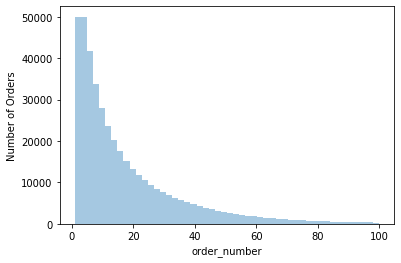

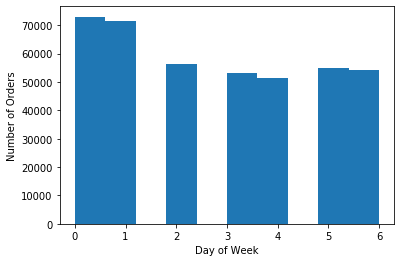

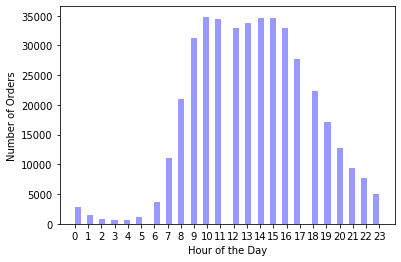

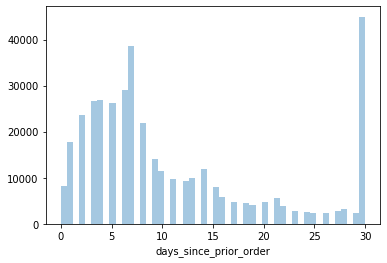

In [180]:
sns.distplot(orders.order_number, kde = False)
plt.ylabel("Number of Orders")
plt.show()

plt.hist(orders.order_dow)
plt.ylabel("Number of Orders")
plt.xlabel("Day of Week")
plt.show()

sns.distplot(orders.order_hour_of_day, kde = False, color = "blue")
plt.xticks(range(0,24))
plt.ylabel("Number of Orders")
plt.xlabel("Hour of the Day")
plt.show()

sns.distplot(orders.days_since_prior_order.dropna(), hist = True, kde = False)
plt.show()

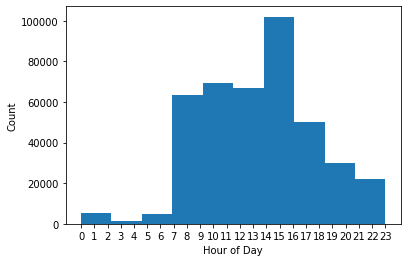

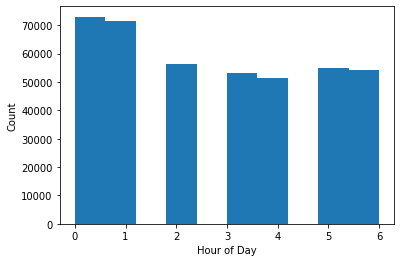

In [131]:
plt.hist(orders.order_hour_of_day)
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0,24))
plt.show()

plt.hist(orders.order_dow)
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()

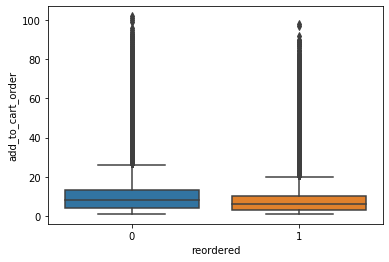

In [67]:
sns.boxplot(order_products.reordered, order_products.add_to_cart_order)

looking at order_products table

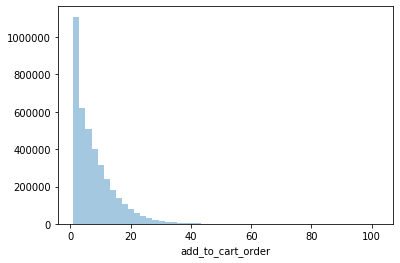

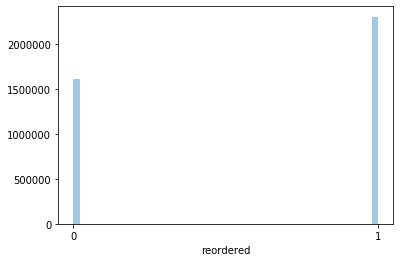

In [7]:
sns.distplot(order_products.add_to_cart_order, kde = False)
plt.show()

sns.distplot(order_products.reordered, kde = False)
plt.xticks([0,1])
plt.show()

## Answering Basic Questions

In [186]:
sellers_order_id = order_products.groupby("product_id").count()["order_id"]
sellers_product_id = np.array([sellers_order_id.index, sellers_order_id.values])

sales_by_product = full_product_info[full_product_info["product_id"].isin(sellers_product_id[0])].assign(number_of_sales = sellers_order_id.values)
sales_by_product.head()

,product_id,product_name,aisle_id,department_id,aisle,department,number_of_sales
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,231
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,11
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,44
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,35
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,9


In [187]:
# top selling products
sales_by_product.nlargest(10, "number_of_sales").drop(["product_id", "aisle_id", "department_id", "aisle", "department"], axis=1)

,product_name,number_of_sales
24851,Banana,58231
13175,Bag of Organic Bananas,45699
21136,Organic Strawberries,32203
21902,Organic Baby Spinach,29380
47208,Organic Hass Avocado,25958
47765,Organic Avocado,21642
47625,Large Lemon,18581
26208,Limes,17399
16796,Strawberries,17217
27844,Organic Whole Milk,16468


In [82]:
print(sales_by_product.loc[sales_by_product['n_sales'] == 1].head(100)) # number of products that only sold once 
# print(sales_by_product.loc[sales_by_product['n_sales'] < 0.1 * sales_by_product.n_sales.mean()].head()) # number of products that sold less than 10% of the average sales per product

     product_id                                       product_name  aisle_id  \
12           13                                  Saline Nasal Mist        11   
18           19   Gluten Free Quinoa Three Cheese & Mushroom Blend        63   
20           21                   Small & Medium Dental Dog Treats        40   
47           48                      School Glue, Washable, No Run        87   
79           80                      French  Tarragon Wine Vinegar        19   
88           89                     Yogurt Fruit Dip Sliced Apples       123   
91           92             Meat In The Middle Large Rawhide Chews        40   
97           98                          2% Yellow American Cheese         2   
102         103                              Sprouted Kale Cracker        78   
124         125    Herbal Armor DEET-Free Natural Insect Repellant       118   
132         133                        Purifying Daily Detox Scrub       109   
134         135                   Dark C

In [11]:
# 80% of sales come from 10% of products
sales_by_product.nlargest(int(.1*len(sales_by_product)), "n_sales")["n_sales"].sum() / sales_by_product["n_sales"].sum()

0.7940683849382281

In [12]:
# 6874 products were never ordered
len(full_product_info) - len(sales_by_product)

6874

In [191]:
# sales by department
sales_by_product.groupby("department").sum().nlargest(5, "number_of_sales").drop(["product_id", "aisle_id", "department_id"], axis=1)

,number_of_sales
department,
produce,1152333
dairy eggs,655902
snacks,349751
beverages,325248
frozen,269145


In [189]:
# top selling aisles
sales_by_product.groupby("aisle").sum().nlargest(5, "number_of_sales").drop(["product_id", "aisle_id", "department_id"], axis=1)

,number_of_sales
aisle,
fresh fruits,443180
fresh vegetables,416040
packaged vegetables fruits,214421
yogurt,176682
packaged cheese,117396


In [190]:
# bottoms selling aisles
sales_by_product.groupby("aisle").sum().nsmallest(5, "number_of_sales").drop(["product_id", "aisle_id", "department_id"], axis=1)

,number_of_sales
aisle,
frozen juice,554
beauty,754
baby accessories,921
eye ear care,1046
baby bath body care,1048


25000


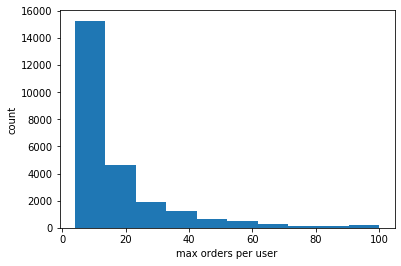

10.0

In [91]:
# number of users
n_users = len(orders.groupby(["user_id"]).max())
print(n_users)

max_orders_per_user = orders.groupby(["user_id"]).max()
# max_orders_per_user.columns = ["user_id", "order_number"]
# print(max_orders_per_user)

plt.hist(max_orders_per_user["order_number"].values)
plt.xlabel("max orders per user")
plt.ylabel("count")
plt.show()

np.median(max_orders_per_user["order_number"].values)

In [55]:
# 50% of users have <= 10 orders
len(max_orders_per_user.loc[max_orders_per_user["order_number"] < 11])/len(max_orders_per_user)

,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
user_id,,,,,
2,3268552,15,5,15,30.0
8,2979257,4,6,14,30.0
11,2921164,8,6,13,30.0
12,1916106,6,5,20,30.0
28,3331846,25,5,19,30.0
31,3352995,21,5,17,18.0
36,3285797,38,6,21,25.0
47,2906490,6,6,22,16.0
62,3349827,11,6,20,30.0


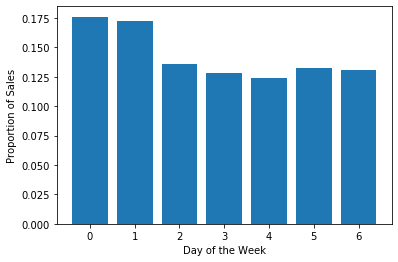

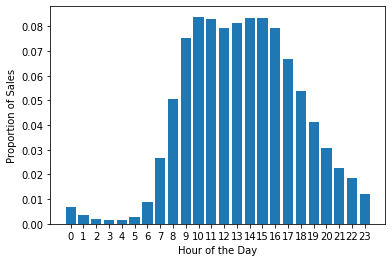

11.5

In [183]:
# top 1% of users
top_1_perc_users = max_orders_per_user.index

top_users_order_dow = orders.loc[orders.user_id.isin(top_1_perc_users)].groupby("order_dow").count()
plt.bar(top_users_order_dow["order_id"].index, top_users_order_dow["order_id"].values/sum(top_users_order_dow["order_id"].values))
plt.xlabel("Day of the Week")
plt.ylabel("Proportion of Sales")
# plt.title("Top 1% users")
plt.show()

top_users_order_hod = orders.loc[orders.user_id.isin(top_1_perc_users)].groupby("order_hour_of_day").count()
plt.bar(top_users_order_hod["order_id"].index, top_users_order_hod["order_id"].values/sum(top_users_order_hod["order_id"].values))
# plt.title("Top 1% users")
plt.xlabel("Hour of the Day")
plt.xticks(range(0,24))
plt.ylabel("Proportion of Sales")
plt.show()

# orders_of_top_users = orders.loc[orders["user_id"].isin(top_1_perc_users)]
# order_products_top_users = order_products.loc[order_products["order_id"].isin(orders_of_top_users["order_id"])]
# full_product_info.loc[full_product_info["product_id"].isin(order_products_top_users["product_id"])].nlargest(10, )

np.mean(top_users_order_hod["order_id"].index)

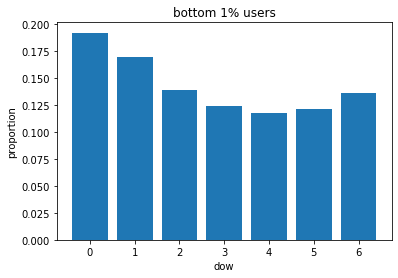

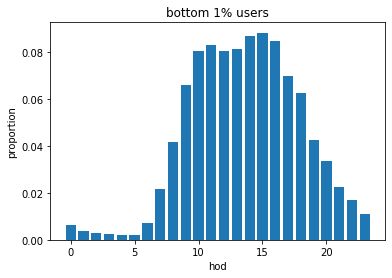

In [93]:
# bot 1% of users
bot_1_perc_users = max_orders_per_user.nsmallest(int(.1*len(max_orders_per_user)), "order_number").index

bot_users_order_dow = orders.loc[orders.user_id.isin(bot_1_perc_users)].groupby("order_dow").count()
plt.bar(bot_users_order_dow["order_id"].index, bot_users_order_dow["order_id"].values/sum(bot_users_order_dow["order_id"].values))
plt.xlabel("dow")
plt.title("bottom 1% users")
plt.ylabel("proportion")

plt.show()

bot_users_order_hod = orders.loc[orders.user_id.isin(bot_1_perc_users)].groupby("order_hour_of_day").count()
plt.bar(bot_users_order_hod["order_id"].index, bot_users_order_hod["order_id"].values/sum(bot_users_order_hod["order_id"].values))
plt.title("bottom 1% users")
plt.xlabel("hod")
plt.ylabel("proportion")

plt.show()

In [65]:
stats.ttest_ind(top_users_order_dow["order_id"].index, bot_users_order_dow["order_id"].index)
stats.ttest_ind(top_users_order_hod["order_id"].index, bot_users_order_hod["order_id"].index)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [176]:
reordered_pct_by_product = order_products.groupby("product_id").mean().drop(["order_id", "add_to_cart_order"], axis=1)
low_reorders = reordered_pct_by_product.loc[reordered_pct_by_product["reordered"] < .1]
len(low_reorders) / len(reordered_pct_by_product)

low_reordered_products = full_product_info.loc[full_product_info.product_id.isin(low_reorders.index)]
low_reordered_departments = low_reordered_products.groupby(low_reordered_products.department).count().nlargest(10, "department_id")
low_reordered_departments

low_reordered_aisles = low_reordered_products.groupby(low_reordered_products.aisle).count().nlargest(10, "aisle_id")
low_reordered_aisles

# top_reordered = reorded_pct_by_product.nlargest(5, "reordered")
# top_reordered_products = full_product_info.loc[full_product_info["product_id"].isin(top_reordered.index)].assign(reordered_pct = top_reordered["reordered"].values)
# top_reordered_products

# bot_reordered = reorded_pct_by_product.nsmallest(10, "reordered")
# bot_reordered = reorded_pct_by_product.loc[reorded_pct_by_product["reordered"] < 0.1]
# bot_reordered_products = full_product_info.loc[full_product_info["product_id"].isin(bot_reordered.index)].assign(reordered_pct = bot_reordered["reordered"].values)
# print(len(bot_reordered_products))
# print(len(bot_reordered_products) / len(full_product_info))

,product_id,product_name,aisle_id,department_id,department
aisle,,,,,
missing,481,481,481,481,481
spices seasonings,472,472,472,472,472
vitamins supplements,455,455,455,455,455
hair care,363,363,363,363,363
candy chocolate,290,290,290,290,290
tea,231,231,231,231,231
cleaning products,229,229,229,229,229
other,220,220,220,220,220
baking ingredients,213,213,213,213,213


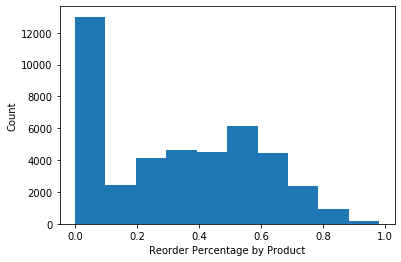

In [116]:

plt.hist(reorded_pct_by_product.reordered)
plt.ylabel("Count")
plt.xlabel("Reorder Percentage by Product")
plt.show()
# sampled_reorded_pct_by_product

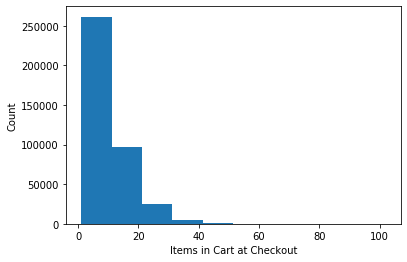

10.066880124790904
0.84
0.15


In [177]:
# what types of products are added to the cart first?

avg_items_per_order = order_products.groupby("order_id").mean()["add_to_cart_order"]
max_items_per_order = order_products.groupby("order_id").max()["add_to_cart_order"]

plt.hist(max_items_per_order)
plt.xlabel("Items in Cart at Checkout")
plt.ylabel("Count")
plt.show()

med_items = np.mean(max_items_per_order)
print(med_items)

num_times_product_added_first = order_products.loc[order_products["add_to_cart_order"] < int(.5 * med_items)].groupby("product_id").count()
print(sum(full_product_info.join(num_times_product_added_first, on = "product_id").nlargest(100, "add_to_cart_order")["product_name"].isin(sales_by_product.nlargest(100, "n_sales")["product_name"]))/100)

print(sum(full_product_info.join(num_times_product_added_first, on = "product_id").nsmallest(100, "add_to_cart_order")["product_name"].isin(sales_by_product.nsmallest(100, "n_sales")["product_name"]))/100)

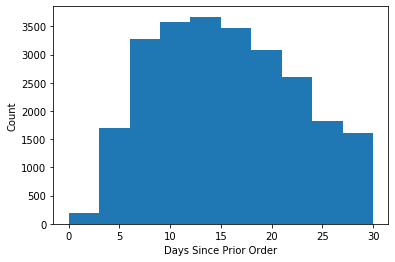

15.493397537859892

In [128]:
orders.days_since_prior_order.isnull().sum() / len(orders)

len(orders.loc[orders.days_since_prior_order == 30]) / len(orders)

mean_days_since_prior_order = orders.groupby("user_id").mean()
plt.hist(mean_days_since_prior_order.days_since_prior_order)
plt.xlabel("Days Since Prior Order")
plt.ylabel("Count")
plt.show()
mean_days_since_prior_order.days_since_prior_order.mean()
# len(mean_days_since_prior_order.loc[mean_days_since_prior_order.days_since_prior_order < 21]) / len(mean_days_since_prior_order)

# min_days_since_prior_order = orders.groupby("user_id").min()
# len(min_days_since_prior_order.loc[min_days_since_prior_order.days_since_prior_order == 30].groupby("user_id").count()) / len(orders.groupby("user_id").count())


In [23]:
# order_products.groupby(["order_id"])['product_id'].apply(list).to_dict()
order_products.loc[order_products.product_id.isin(sales_by_product.nlargest(100, "n_sales")["product_id"])]

,order_id,product_id,add_to_cart_order,reordered
1,2,28985,2,1
5,2,17794,6,1
22,15,19660,1,1
27,19,42265,1,1
28,19,24838,2,1
30,27,13176,1,1
36,27,47766,7,1
37,27,17794,8,1
39,27,21938,10,0
45,27,28985,16,1


In [24]:
orders_of_best_sellers = order_products.loc[order_products.product_id.isin(sales_by_product.nlargest(50, "n_sales")["product_id"])]
orders_of_best_sellers_name = orders_of_best_sellers.merge(full_product_info, on = "product_id")
encoded_order_products = orders_of_best_sellers_name.groupby(["order_id", "product_name"])['add_to_cart_order'].sum().unstack().reset_index().fillna(0).set_index('order_id')

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
OH_encoded_order_products = encoded_order_products.applymap(encode_units)

frequent_itemsets = apriori(OH_encoded_order_products, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

# “Frequently Bought Together”
# support - default popularity of an item. ratio of transactions involving A to the total number of transactions
# confidence - Likelihood that customer who bought both A and B
# lift - Increase in the sale of A when you sell B
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Apple Honeycrisp Organic),(Bag of Organic Bananas),0.040776,0.181656,0.011297,0.277052,1.525147,0.003890,1.131954
1,(Bag of Organic Bananas),(Apple Honeycrisp Organic),0.181656,0.040776,0.011297,0.062190,1.525147,0.003890,1.022833
2,(Bag of Organic Bananas),(Organic Baby Spinach),0.181656,0.116787,0.024892,0.137027,1.173307,0.003677,1.023454
3,(Organic Baby Spinach),(Bag of Organic Bananas),0.116787,0.181656,0.024892,0.213138,1.173307,0.003677,1.040010
4,(Organic Blueberries),(Bag of Organic Bananas),0.047788,0.181656,0.010431,0.218267,1.201538,0.001750,1.046833


In [25]:
rules.nlargest(10, "lift")

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
54,(Organic Garlic),(Organic Yellow Onion),0.052220,0.053087,0.010415,0.199437,3.756802,0.007642,1.182809
55,(Organic Yellow Onion),(Organic Garlic),0.053087,0.052220,0.010415,0.196181,3.756802,0.007642,1.179096
38,(Large Lemon),(Limes),0.073860,0.069162,0.013797,0.186804,2.700961,0.008689,1.144666
39,(Limes),(Large Lemon),0.069162,0.073860,0.013797,0.199494,2.700961,0.008689,1.156943
60,(Organic Strawberries),(Organic Raspberries),0.128009,0.064416,0.016210,0.126634,1.965889,0.007964,1.071240
61,(Organic Raspberries),(Organic Strawberries),0.064416,0.128009,0.016210,0.251651,1.965889,0.007964,1.165220
52,(Organic Blueberries),(Organic Strawberries),0.047788,0.128009,0.011389,0.238313,1.861696,0.005271,1.144816
53,(Organic Strawberries),(Organic Blueberries),0.128009,0.047788,0.011389,0.088967,1.861696,0.005271,1.045200
56,(Organic Hass Avocado),(Organic Raspberries),0.103184,0.064416,0.012323,0.119424,1.853952,0.005676,1.062468
57,(Organic Raspberries),(Organic Hass Avocado),0.064416,0.103184,0.012323,0.191299,1.853952,0.005676,1.108958


In [45]:
np.random.seed(1)
random_order_ids = full_product_info["product_id"].sample(100)
random_orders = order_products.loc[order_products.product_id.isin(random_order_ids.values)]
random_orders_names = random_orders.merge(full_product_info, on = "product_id")
encoded_random_orders_names = random_orders_names.groupby(["order_id", "product_name"])['add_to_cart_order'].sum().unstack().reset_index().fillna(0).set_index('order_id')
OH_encoded_random_orders_names = encoded_random_orders_names.applymap(encode_units)

frequent_itemsets2 = apriori(OH_encoded_random_orders_names, min_support=0.0001, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

In [46]:
rules2.nlargest(10, "lift")

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(Organic Stage 2 Veggie & Protein Puree Brocco...,(Organic Unsweetened Ketchup),0.007732,0.005778,0.00017,0.021978,3.803814,0.000125,1.016564
5,(Organic Unsweetened Ketchup),(Organic Stage 2 Veggie & Protein Puree Brocco...,0.005778,0.007732,0.00017,0.029412,3.803814,0.000125,1.022337
2,(Soft French-Style Nut Cheese),(Hickory Honey Barbeque Baked Potato Chips),0.003824,0.012151,0.00017,0.044444,3.657809,0.000123,1.033796
3,(Hickory Honey Barbeque Baked Potato Chips),(Soft French-Style Nut Cheese),0.012151,0.003824,0.00017,0.013986,3.657809,0.000123,1.010307
0,(Flourless Sprouted Whole Grain 7-Sprouted Gr...,(Chicken Burgers),0.030929,0.001784,0.00017,0.005495,3.079278,0.000115,1.003731
1,(Chicken Burgers),(Flourless Sprouted Whole Grain 7-Sprouted Gr...,0.001784,0.030929,0.00017,0.095238,3.079278,0.000115,1.071079
